In [1]:
import os
from os.path import dirname
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import confusion_matrix


#from sklearn.model_selection import KFold

In [3]:
d = os.getcwd()
parent_d = dirname(d)
filepath = parent_d + '/data/data_preprocessed.csv'
df = pd.read_csv(filepath)
df.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_ts
0,2539,2787,1,52,40.64749,-73.97237,1,149,1,9,0.21,6,365,1539907200000000000
1,2595,2845,0,9,40.75362,-73.98377,0,225,1,45,0.38,2,355,1558396800000000000
2,3647,4632,0,2,40.80902,-73.94190,1,150,3,0,0.00,1,365,1301270400000000000
3,3831,4869,1,19,40.68514,-73.95976,0,89,1,270,4.64,1,194,1562284800000000000
4,5022,7192,0,10,40.79851,-73.94399,0,80,10,9,0.10,1,0,1542585600000000000


## feature selection

In [4]:
#  Log transformation on price. make less skewed
def log_model(df):
    df_log = df.copy()
    df_log['price_log'] = np.log(df_log.price+1)
    df_log.drop(columns=['id','host_id', 'last_review_ts','price'], axis = 1, inplace = True)
    return df_log

In [5]:
df_log = log_model(df)
df_log

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_log
0,1,52,40.64749,-73.97237,1,1,9,0.21,6,365,5.010635
1,0,9,40.75362,-73.98377,0,1,45,0.38,2,355,5.420535
2,0,2,40.80902,-73.94190,1,3,0,0.00,1,365,5.017280
3,1,19,40.68514,-73.95976,0,1,270,4.64,1,194,4.499810
4,0,10,40.79851,-73.94399,0,10,9,0.10,1,0,4.394449
...,...,...,...,...,...,...,...,...,...,...,...
48890,1,1,40.67853,-73.94995,1,2,0,0.00,2,9,4.262680
48891,1,3,40.70184,-73.93317,1,4,0,0.00,2,36,3.713572
48892,0,2,40.81475,-73.94867,0,10,0,0.00,1,27,4.753590
48893,0,5,40.75751,-73.99112,2,1,0,0.00,6,2,4.025352


Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'price_log'],
      dtype='object')

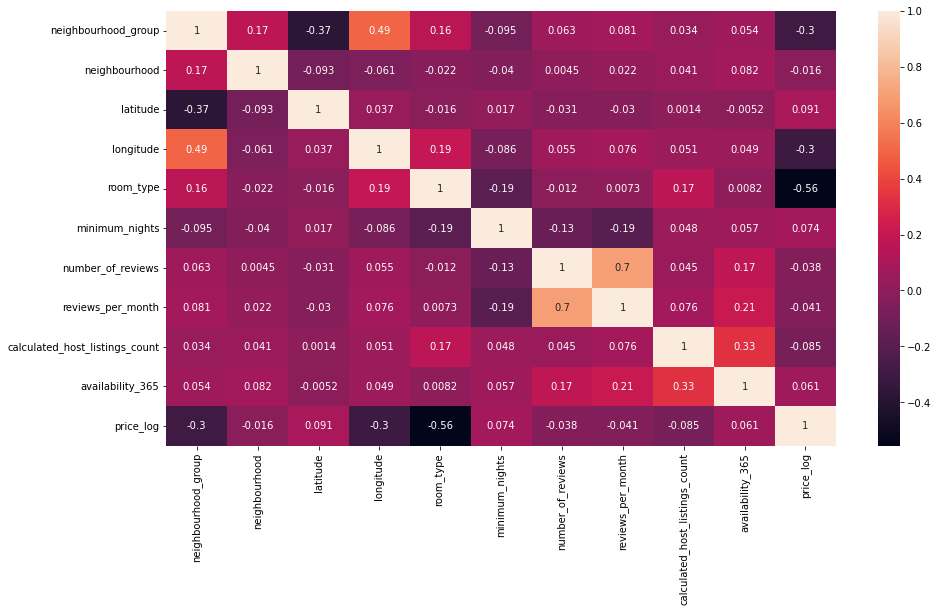

In [6]:
corr = df_log.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
df_log.columns

In [7]:
# Train test splitting with desired parameters.
def get_train_test_split(df, test_size = 0.2, random_state = 1, scale=True):
        '''
        @param:
            df: dataframe to be split
            test_size: Test data size as the fraction of whole data size.
            random_state: Random state to be used in splitting.
        @return:
            Train features, train labels, test features, test labels are returned in separate Pandas Dataframes in a tuple size of 4.
        '''
        assert isinstance(test_size, (float, int))
        assert isinstance(random_state, (int))
        
        model_x, model_y = df.iloc[:,:-1], df.iloc[:,-1] # df.loc[:, df.columns != 'price']   df.loc[:, df.columns == 'price']
        
        if scale==True:
            scaler = StandardScaler()
            model_x = scaler.fit_transform(model_x)
        else:
            model_x = model_x.copy()
            
        X_train, X_test, y_train, y_test = train_test_split(model_x, model_y , test_size=test_size, random_state=random_state)
        
        return X_train, X_test, y_train, y_test

In [8]:
def feature_importance(df,scale=True):
    '''
        @param:
            scale: True by default, scales the features.
        @return:
            dataframe with final features.
    '''
            
    # Get Train and Test data
    X_train, X_test, y_train, y_test = get_train_test_split(df, test_size = 0.2, random_state = 1)
    
    lab_enc = preprocessing.LabelEncoder()

    feature_model = ExtraTreesClassifier(n_estimators=50)
    feature_model.fit(X_train,lab_enc.fit_transform(y_train))

    plt.figure(figsize=(7,7))
    feat_importances = pd.Series(feature_model.feature_importances_, index=df.iloc[:,:-1].columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()

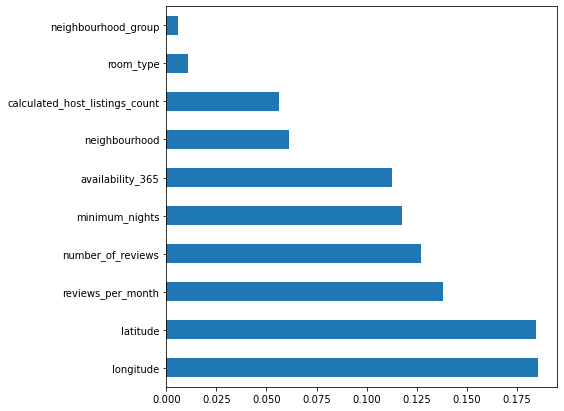

In [9]:
feature_importance(df_log)

In [10]:
def drop_column(df,save=True):
    df_new = df.copy()
    df_new.drop(columns=['id','host_id', 'last_review_ts','neighbourhood_group', 'room_type'], axis = 1, inplace = True)
    index = ['neighbourhood', 'latitude', 'longitude',
             'minimum_nights', 'number_of_reviews','reviews_per_month', 
             'calculated_host_listings_count', 'availability_365','price',]
    df_new=df_new[index]
    
    if save==True:
        df_new.to_csv(parent_d + '/data/data_feature.csv', index=False)
        
    return df_new

In [11]:
df_feature = drop_column(df,save=True)
df_feature

,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
0,52,40.64749,-73.97237,1,9,0.21,6,365,149
1,9,40.75362,-73.98377,1,45,0.38,2,355,225
2,2,40.80902,-73.94190,3,0,0.00,1,365,150
3,19,40.68514,-73.95976,1,270,4.64,1,194,89
4,10,40.79851,-73.94399,10,9,0.10,1,0,80
...,...,...,...,...,...,...,...,...,...
48890,1,40.67853,-73.94995,2,0,0.00,2,9,70
48891,3,40.70184,-73.93317,4,0,0.00,2,36,40
48892,2,40.81475,-73.94867,10,0,0.00,1,27,115
48893,5,40.75751,-73.99112,1,0,0.00,6,2,55


## model selection

In [12]:
def make_predictions(df, model = 'lr', cv=5, tune = False, save = False):
    '''
     @param:
        df: dataframe to be used
        model: Name of the model 
        tune: tune the hyper parameters or not
        save: save the result, to /data folder.
    @return:
        predictions on the test data with the original test features.
    '''

    # Get Train and Test data
    X_train, X_test, y_train, y_test = get_train_test_split(df, test_size = 0.2, random_state = 1, scale=True)
    
    # Training and Prediction with Different Models
    #  Linear Regression
    if model == 'lr':
        if tune == True:
            clf_lr = LinearRegression()
            parameters = {'copy_X':[True, False], 'fit_intercept':[True,False], 'normalize':[True,False]}
            
            grid_search_lr = GridSearchCV(estimator=clf_lr,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)
            
            grid_search_lr.fit(X_train, y_train)
            best_parameters_lr = grid_search_lr.best_params_  
            best_score_lr = grid_search_lr.best_score_ 
        else:
            best_parameters_lr =  {'copy_X':True, 'fit_intercept': True, 'normalize': True}
        
        clf = LinearRegression(**best_parameters_lr)
    
    # Ridge Regression
    if model == 'rr':
        if tune == True:
            clf_rr = Ridge()
            parameters = {'alpha' :np.array([1,0.1,0.01,0.001,0.0001,0]),'normalize':[True,False]}           
            
            grid_search_rr = GridSearchCV(estimator=clf_rr,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)
            
            grid_search_rr.fit(X_train, y_train)
            best_parameters_rr = grid_search_rr.best_params_  
            best_score_rr = grid_search_rr.best_score_ 
        else:
            best_parameters_rr =  {'alpha':0.01, 'normalize': True}
            
        clf = Ridge(**best_parameters_rr)
    
    # Lasso Regression
    if model=='l':
        if tune == True:
            clf_l =  Lasso()
            parameters = {'alpha' :np.array([1,0.1,0.01,0.001,0.0001,0]),'normalize':[True,False]}           
            
            grid_search_l = GridSearchCV(estimator=clf_l,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)
            
            grid_search_l.fit(X_train, y_train)
            best_parameters_l = grid_search_l.best_params_  
            best_score_l = grid_search_l.best_score_ 
        else:
            best_parameters_l =  {'alpha':0.001, 'normalize' :False}
            
        clf = Lasso(**best_parameters_l)
        
    # ElasticNet Regression 
    if model=='er':
        if tune == True:
            clf_er =  ElasticNet()
            parameters = {'alpha' :np.array([1,0.1,0.01,0.001,0.0001,0]),'normalize':[True,False]}           
            
            grid_search_er = GridSearchCV(estimator=clf_er,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)
            
            grid_search_er.fit(X_train, y_train)
            best_parameters_er = grid_search_er.best_params_  
            best_score_er = grid_search_er.best_score_ 
        else:
            best_parameters_er =  {'alpha': 0.01, 'normalize':False}
            
        clf =  ElasticNet(**best_parameters_er)
        
                          
    # Random Forest Regressor
    if model=='rfr':
        if tune == True:
            
            clf_rfr = RandomForestRegressor()
            max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
            max_depth.append(None)
            min_samples_split = [2,5,10]
            min_samples_leaf = [1, 2, 4]
            bootstrap = [True, False]
            parameters = {'n_estimators' :[int(x) for x in np.linspace(start = 200, stop=2000,num=10)],
                          'max_features':['auto', 'sqrt'],
                          'max_depth' :max_depth,
                          'min_samples_split':[2,5,10],
                          'min_samples_leaf':[1, 2, 4],
                          'bootstrap': [True, False]}
            grid_search_rfr = GridSearchCV(estimator=clf_rfr,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)
            
            grid_search_rfr.fit(X_train, y_train)
            best_parameters_rfr = grid_search_rfr.best_params_  
            best_score_rfr = grid_search_rfr.best_score_ 
        else:
            best_parameters_rfr =  {'n_estimators': 100, 'max_features':'sqrt','max_depth':None,
                                    'min_samples_split':2, 'min_samples_leaf':1, 'bootstrap': True}
            
        clf =  RandomForestRegressor(**best_parameters_rfr)
        
    # XGBoost Regressor
    if model == 'xgb':
        if tune == True:
            clf_xgb = XGBRegressor()
            parameters = { 'learning_rate': [0.01, 0.05, 0.1, 0.5],
                           'max_depth': [3,5,7,9],
                           'min_child_weight':[1,3,5]}

            grid_search_xgb= GridSearchCV(estimator=clf_xgb,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)
            
            grid_search_xgb.fit(X_train, y_train)
            best_parameters_xgb = grid_search_xgb.best_params_  
            best_score_xgb = grid_search_xgb.best_score_ 

        else:
            best_parameters_xgb  =  {'learning_rate':0.1, 'max_depth':3, 'min_child_weight':3}
        
        clf = XGBRegressor(**best_parameters_xgb)                                         
                          

    # model fit, predict
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    #probs = clf.predict_proba(X_test)
    #accuracy = accuracy_score(y_test, pred)
    #conf = confusion_matrix(y_test, pred)
    
    x = X_test.copy()
    y = y_test.copy()
    index = ['neighbourhood', 'latitude', 'longitude',
             'minimum_nights', 'number_of_reviews','reviews_per_month', 
             'calculated_host_listings_count', 'availability_365']
    df_pred = pd.DataFrame(x, columns = index)
    #df_pred['price'] = y
    df_pred['pred'] = pred
    #df_pred['prob_1'] = probs[:, 1]
                
    if save == True:
        df_pred.to_csv(parent_d + '\data\predictions.csv', index = False)
    
    print(model)
    print('MAE: %f'% mean_absolute_error(y_test, pred))
    print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred)))   
    print('R2 %f' % r2_score(y_test, pred))
                
    return df_pred            

In [13]:
#Linear Regression
make_predictions(df_feature, model = 'lr', cv=5, tune = True, save = False)

lr
MAE: 86.897628
RMSE: 249.135478
R2 0.032354


,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,pred
0,0.696237,0.311962,1.615157,-0.245240,-0.522433,-0.682986,-0.156104,-0.355425,93.501265
1,-0.268844,0.547981,0.662307,-0.245240,-0.522433,-0.682986,-0.186451,1.285652,173.467770
2,0.063942,-0.591402,-0.489649,-0.293996,0.667238,0.663064,-0.186451,-0.856865,132.878685
3,-0.368680,-0.084337,0.013641,-0.293996,2.148715,0.926013,-0.156104,-0.849267,103.520117
4,-0.535074,-0.025837,-0.723204,-0.196484,-0.253074,-0.564032,-0.156104,-0.856865,163.709895
...,...,...,...,...,...,...,...,...,...
9774,3.524925,2.231289,1.075902,0.339830,-0.410200,-0.601597,-0.186451,1.589555,180.042697
9775,-0.734746,-0.448360,0.186315,-0.050217,-0.410200,0.675586,-0.186451,-0.552962,129.053572
9776,0.030664,-1.429480,0.071705,-0.245240,5.381029,1.001142,-0.156104,0.176406,75.861367
9777,-0.701467,-0.890323,0.440669,-0.001461,0.667238,0.018212,-0.156104,-0.271851,112.437501


In [14]:
##Ridge Regression
make_predictions(df_feature, model = 'rr', cv=5, tune = True, save = False)

rr
MAE: 86.840623
RMSE: 249.130292
R2 0.032395


,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,pred
0,0.696237,0.311962,1.615157,-0.245240,-0.522433,-0.682986,-0.156104,-0.355425,94.152478
1,-0.268844,0.547981,0.662307,-0.245240,-0.522433,-0.682986,-0.186451,1.285652,173.175789
2,0.063942,-0.591402,-0.489649,-0.293996,0.667238,0.663064,-0.186451,-0.856865,133.083931
3,-0.368680,-0.084337,0.013641,-0.293996,2.148715,0.926013,-0.156104,-0.849267,104.140298
4,-0.535074,-0.025837,-0.723204,-0.196484,-0.253074,-0.564032,-0.156104,-0.856865,163.667238
...,...,...,...,...,...,...,...,...,...
9774,3.524925,2.231289,1.075902,0.339830,-0.410200,-0.601597,-0.186451,1.589555,179.383788
9775,-0.734746,-0.448360,0.186315,-0.050217,-0.410200,0.675586,-0.186451,-0.552962,129.300143
9776,0.030664,-1.429480,0.071705,-0.245240,5.381029,1.001142,-0.156104,0.176406,76.948300
9777,-0.701467,-0.890323,0.440669,-0.001461,0.667238,0.018212,-0.156104,-0.271851,113.011656


In [15]:
##Lasso Regression
make_predictions(df_feature, model = 'l', cv=5, tune = True, save = False)

l
MAE: 86.841411
RMSE: 249.137056
R2 0.032342


,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,pred
0,0.696237,0.311962,1.615157,-0.245240,-0.522433,-0.682986,-0.156104,-0.355425,93.794070
1,-0.268844,0.547981,0.662307,-0.245240,-0.522433,-0.682986,-0.186451,1.285652,173.023591
2,0.063942,-0.591402,-0.489649,-0.293996,0.667238,0.663064,-0.186451,-0.856865,133.338577
3,-0.368680,-0.084337,0.013641,-0.293996,2.148715,0.926013,-0.156104,-0.849267,104.149169
4,-0.535074,-0.025837,-0.723204,-0.196484,-0.253074,-0.564032,-0.156104,-0.856865,163.663826
...,...,...,...,...,...,...,...,...,...
9774,3.524925,2.231289,1.075902,0.339830,-0.410200,-0.601597,-0.186451,1.589555,179.828879
9775,-0.734746,-0.448360,0.186315,-0.050217,-0.410200,0.675586,-0.186451,-0.552962,129.204337
9776,0.030664,-1.429480,0.071705,-0.245240,5.381029,1.001142,-0.156104,0.176406,77.075078
9777,-0.701467,-0.890323,0.440669,-0.001461,0.667238,0.018212,-0.156104,-0.271851,112.750263


In [16]:
##ElasticNet Regression 
make_predictions(df_feature, model = 'er', cv=5, tune = True, save = False)

er
MAE: 86.867131
RMSE: 249.132757
R2 0.032376


,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,pred
0,0.696237,0.311962,1.615157,-0.245240,-0.522433,-0.682986,-0.156104,-0.355425,93.836888
1,-0.268844,0.547981,0.662307,-0.245240,-0.522433,-0.682986,-0.186451,1.285652,173.308180
2,0.063942,-0.591402,-0.489649,-0.293996,0.667238,0.663064,-0.186451,-0.856865,132.994901
3,-0.368680,-0.084337,0.013641,-0.293996,2.148715,0.926013,-0.156104,-0.849267,103.853988
4,-0.535074,-0.025837,-0.723204,-0.196484,-0.253074,-0.564032,-0.156104,-0.856865,163.688116
...,...,...,...,...,...,...,...,...,...
9774,3.524925,2.231289,1.075902,0.339830,-0.410200,-0.601597,-0.186451,1.589555,179.703856
9775,-0.734746,-0.448360,0.186315,-0.050217,-0.410200,0.675586,-0.186451,-0.552962,129.179187
9776,0.030664,-1.429480,0.071705,-0.245240,5.381029,1.001142,-0.156104,0.176406,76.454636
9777,-0.701467,-0.890323,0.440669,-0.001461,0.667238,0.018212,-0.156104,-0.271851,112.736986


In [17]:
# XGBoost Regressor
make_predictions(df_feature, model = 'xgb', cv=5, tune = True, save = False)

xgb
MAE: 77.124956
RMSE: 238.068257
R2 0.116415


,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,pred
0,0.696237,0.311962,1.615157,-0.245240,-0.522433,-0.682986,-0.156104,-0.355425,103.529144
1,-0.268844,0.547981,0.662307,-0.245240,-0.522433,-0.682986,-0.186451,1.285652,167.360214
2,0.063942,-0.591402,-0.489649,-0.293996,0.667238,0.663064,-0.186451,-0.856865,113.173523
3,-0.368680,-0.084337,0.013641,-0.293996,2.148715,0.926013,-0.156104,-0.849267,101.122581
4,-0.535074,-0.025837,-0.723204,-0.196484,-0.253074,-0.564032,-0.156104,-0.856865,155.968903
...,...,...,...,...,...,...,...,...,...
9774,3.524925,2.231289,1.075902,0.339830,-0.410200,-0.601597,-0.186451,1.589555,63.979603
9775,-0.734746,-0.448360,0.186315,-0.050217,-0.410200,0.675586,-0.186451,-0.552962,116.053146
9776,0.030664,-1.429480,0.071705,-0.245240,5.381029,1.001142,-0.156104,0.176406,84.618324
9777,-0.701467,-0.890323,0.440669,-0.001461,0.667238,0.018212,-0.156104,-0.271851,86.420822


In [ ]:
# Random Forest Regressor
make_predictions(df_feature, model = 'rfr', cv=5, tune = True, save = False)